In [2]:
import torch
import h5py
import glob
import random
import numpy as np
from torchvision.models import resnet50
from torch.nn import Identity
from scipy import spatial
import torchvision.transforms as T
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import img_scale
plt.style.use(astropy_mpl_style)

In [3]:
cropper = T.CenterCrop(size=140)
totensor = T.ToTensor()

In [12]:
test_files = glob.glob('/scratch/merileo/unions/cutouts/test/*.h5')

In [13]:
interesting_images = [
['/scratch/merileo/unions/cutouts/test/cutout_stacks_CFISr_PS1i_HSCg_200x200new_679.h5', 2796],
['/scratch/merileo/unions/cutouts/test/cutout_stacks_CFISr_PS1i_HSCg_200x200new_679.h5', 7748],
['/scratch/merileo/unions/cutouts/test/cutout_stacks_CFISr_PS1i_HSCg_200x200new_521.h5', 6737],
['/scratch/merileo/unions/cutouts/test/cutout_stacks_CFISr_PS1i_HSCg_200x200new_485.h5', 7526],
['/scratch/merileo/unions/cutouts/test/cutout_stacks_CFISr_PS1i_HSCg_200x200new_174.h5', 5809],
['/scratch/merileo/unions/cutouts/test/cutout_stacks_CFISr_PS1i_HSCg_200x200new_492.h5', 6846],
['/scratch/merileo/unions/cutouts/test/cutout_stacks_CFISr_PS1i_HSCg_200x200new_137.h5', 9243],
['/scratch/merileo/unions/cutouts/test/cutout_stacks_CFISr_PS1i_HSCg_200x200new_562.h5', 2570],
['/scratch/merileo/unions/cutouts/test/cutout_stacks_CFISr_PS1i_HSCg_200x200new_470.h5', 1040],
['/scratch/merileo/unions/cutouts/test/cutout_stacks_CFISr_PS1i_HSCg_200x200new_415.h5', 1469]]

In [14]:
def process_image(image):
    
    Rdata = image[0,:,:]
    Idata = image[1,:,:]
    Gdata = image[2,:,:]
    
    rsky = img_scale.sky_median_sig_clip(Rdata, 5, 0.01, max_iter=200)[0]
    isky = img_scale.sky_median_sig_clip(Idata, 5, 0.01, max_iter=200)[0]
    gsky = img_scale.sky_median_sig_clip(Gdata, 5, 0.01, max_iter=200)[0]
    
    scale_nsigma = 5.

    Rmean = np.mean(Rdata)
    Rstd = np.std(Rdata)
    Rmax = Rmean + scale_nsigma*Rstd

    Imean = np.mean(Idata)
    Istd = np.std(Idata)
    Imax = Imean + scale_nsigma*Istd

    Gmean = np.mean(Gdata)
    Gstd = np.std(Gdata)
    Gmax = Gmean + scale_nsigma*Gstd
    
    img = np.zeros((image.shape[1], image.shape[2], 3), dtype=float)
    img[:,:,0] = img_scale.asinh(Rdata, scale_min=10*rsky, scale_max=Rmax)
    img[:,:,1] = img_scale.asinh(Idata, scale_min=10*isky, scale_max=Imax)
    img[:,:,2] = img_scale.asinh(Gdata, scale_min=10*gsky, scale_max=Gmax)
    
    return img

## Load in the trainined model

In [4]:
rn50 = resnet50(pretrained=False)
rn50.fc = Identity()

In [5]:
weights = torch.load('/scratch/merileo/visslcheckpoints/n500000/model_phase50.torch')
trunk_weights = weights["classy_state_dict"]["base_model"]["model"]["trunk"]

In [6]:
prefix = "_feature_blocks."
trunk_weights = {k[len(prefix):] : w for k, w in trunk_weights.items()}
rn50.load_state_dict(trunk_weights)
rn50 = rn50.cuda()
rn50.eval()  # This command must be executed before predictions are made

<All keys matched successfully>

## Collect the compressed representations (output of the trained SimCLR network) of a subsample of the test data

In [51]:
filepaths_list = []
filenum_list = []
indx_list = []
output_representations_list = []
for j, filepath in enumerate(test_files):
    print('{} of {} done'.format(j, len(test_files)))
    with h5py.File(filepath, 'r') as f:
        images = f['images'][:]
        images = np.float32(images)
    images = np.swapaxes(images, 1, 3)
    images = np.asarray(([cropper(totensor(image)).detach().numpy() for image in images]))
    for i in range(0, len(images), 10):
        reps = rn50(torch.from_numpy(images[i:i+10]).cuda()).detach().cpu().numpy()
        output_representations_list.extend(reps)
        filepaths_list.extend([filepath]*len(reps))
        indx_list.extend(np.arange(i, i+len(reps)))

0 of 108 done
1 of 108 done
2 of 108 done
3 of 108 done
4 of 108 done
5 of 108 done
6 of 108 done
7 of 108 done
8 of 108 done
9 of 108 done
10 of 108 done
11 of 108 done
12 of 108 done
13 of 108 done
14 of 108 done
15 of 108 done
16 of 108 done
17 of 108 done
18 of 108 done
19 of 108 done


## For each "interesting image" defined above, calculate the cosine similarity between it and every source in the subsample of test data, then plot the 9 most similar examples

#### Note the results are not perfect for a few reasons: 
#### 1. The sizes of the training and test sets, as well as the batch size during training, were limited due to time constraints 
#### 2. Reddening hasn't been included as an augmentation
#### 3. More photometry data would likely be beneficial

<IPython.core.display.Javascript object>


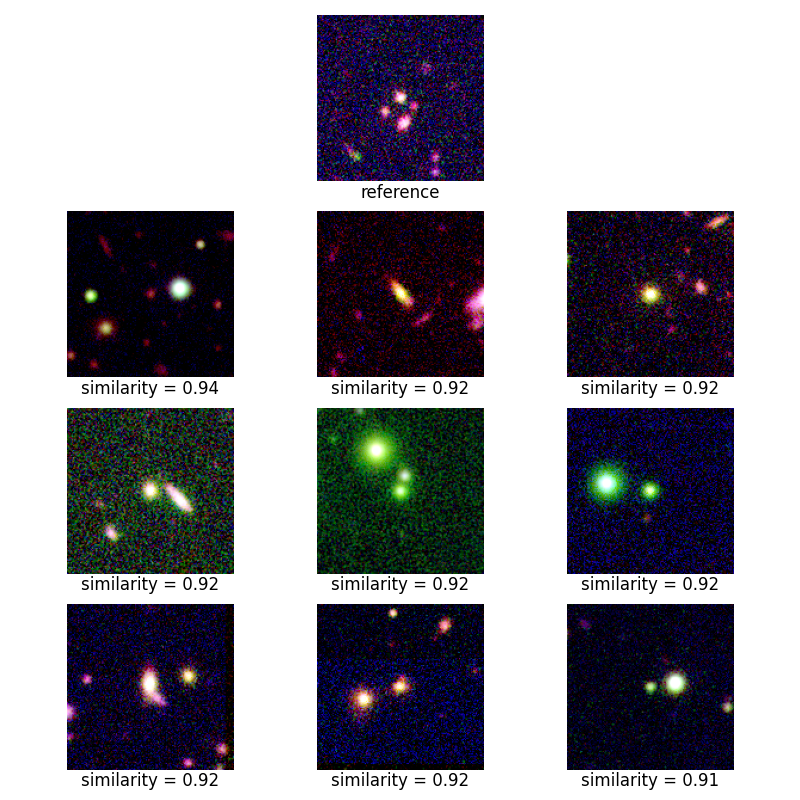

<IPython.core.display.Javascript object>


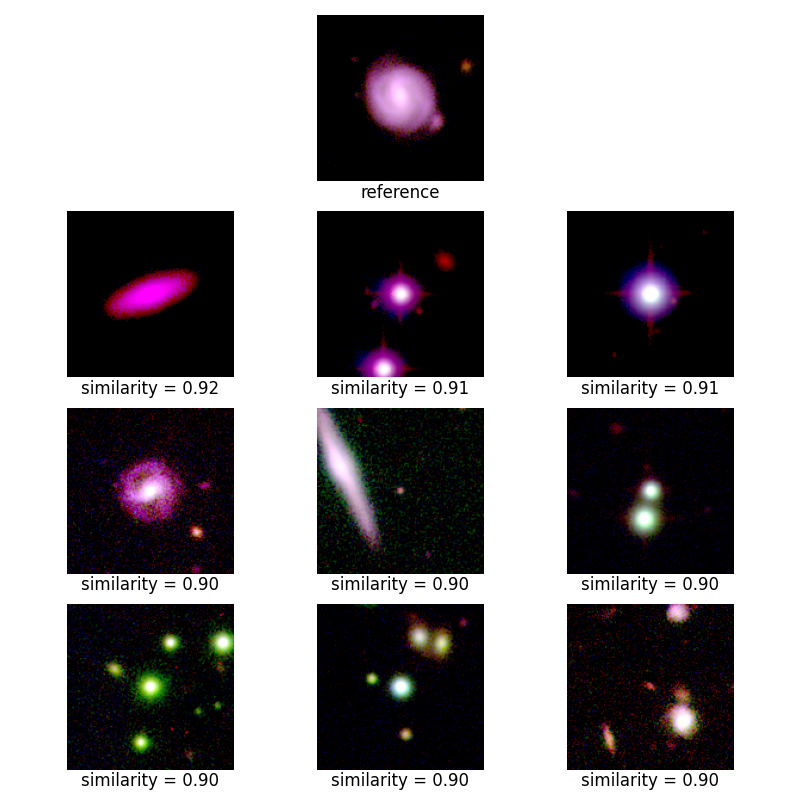

<IPython.core.display.Javascript object>


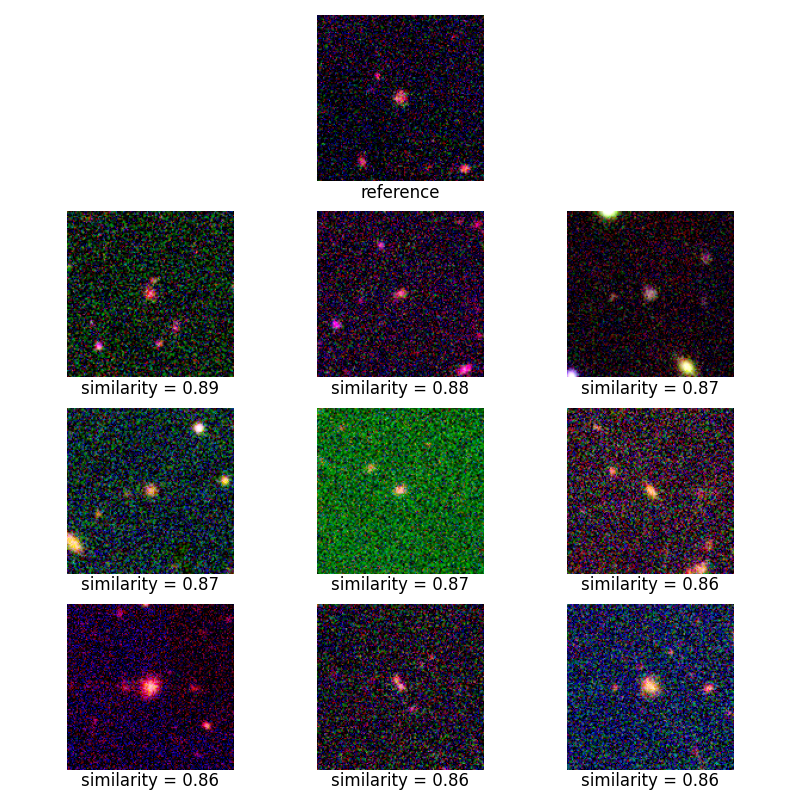

<IPython.core.display.Javascript object>


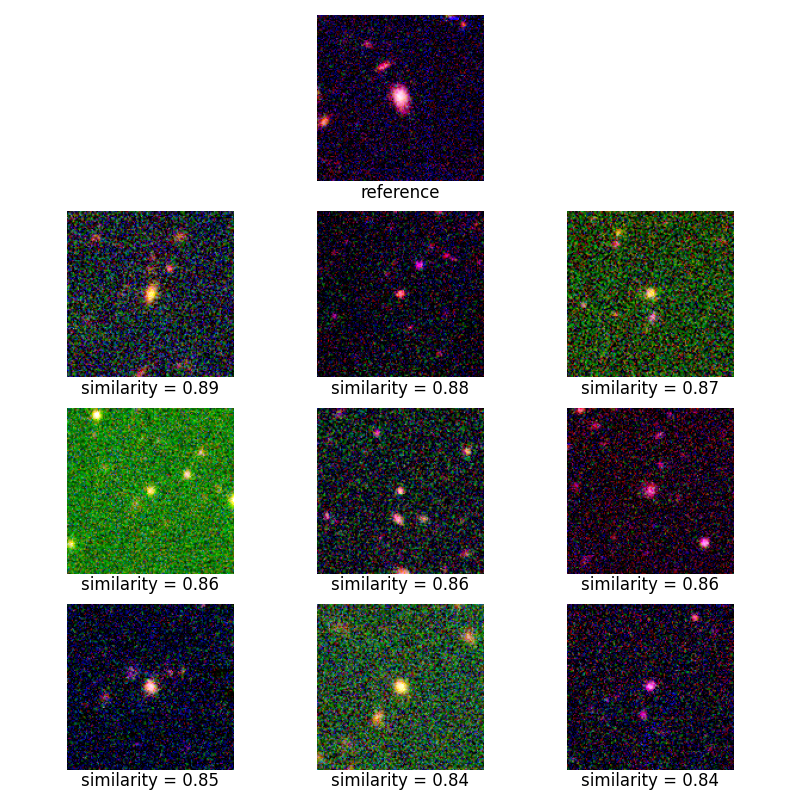

<IPython.core.display.Javascript object>


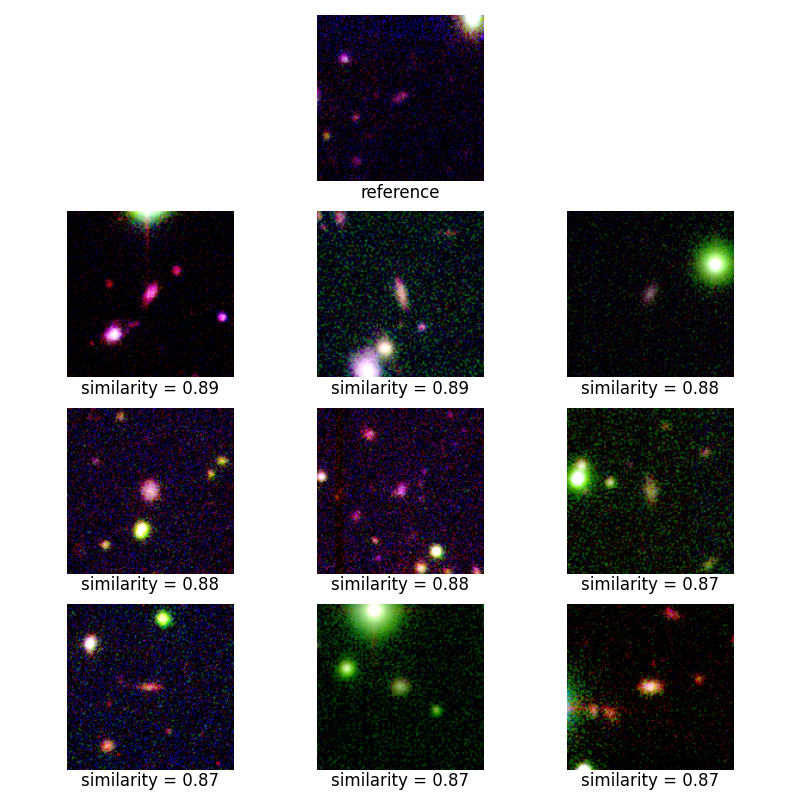

<IPython.core.display.Javascript object>


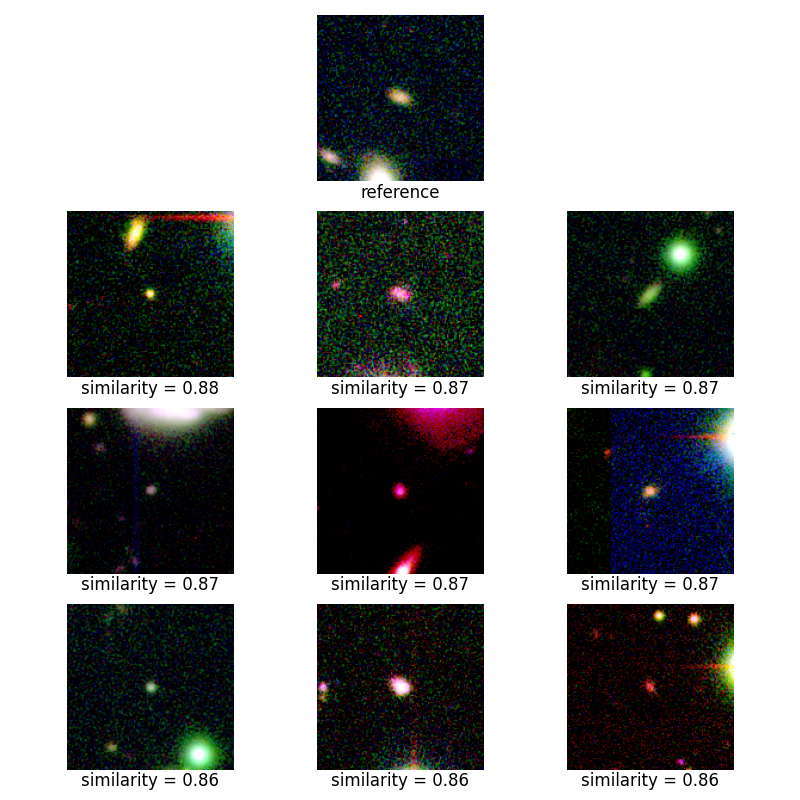

<IPython.core.display.Javascript object>


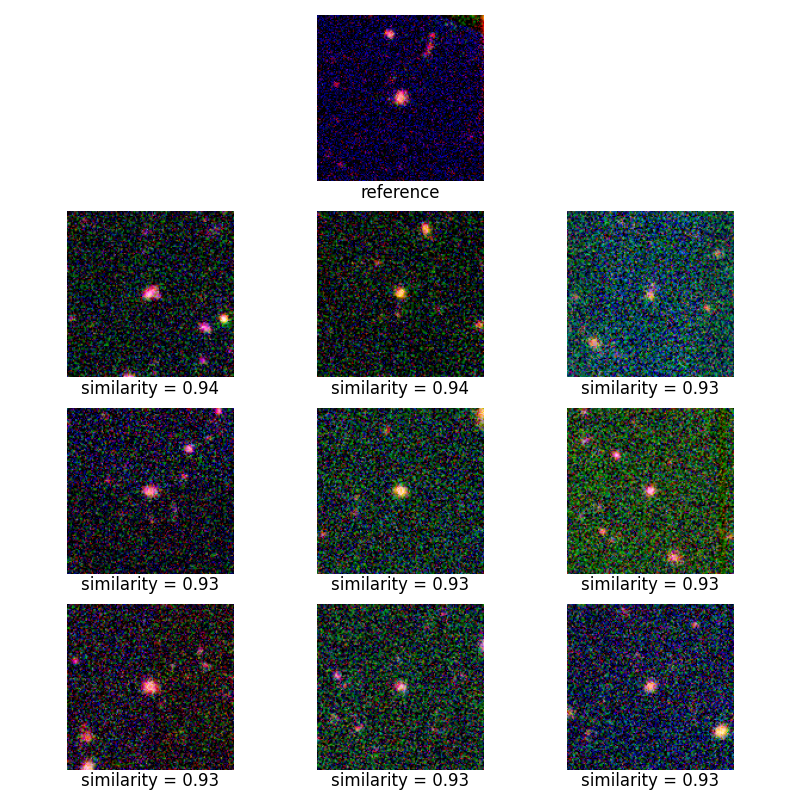

<IPython.core.display.Javascript object>


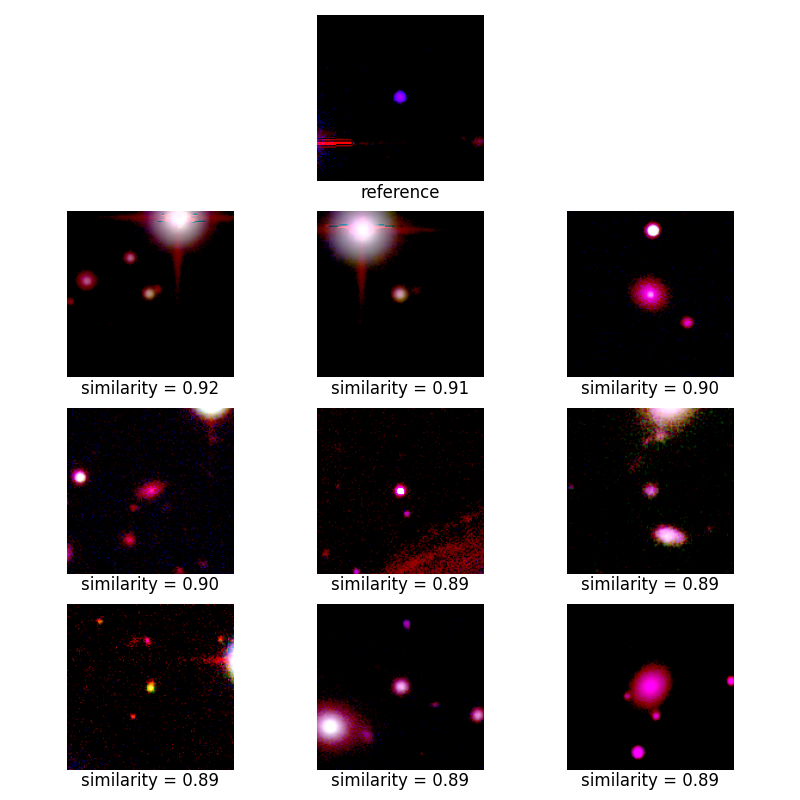

<IPython.core.display.Javascript object>


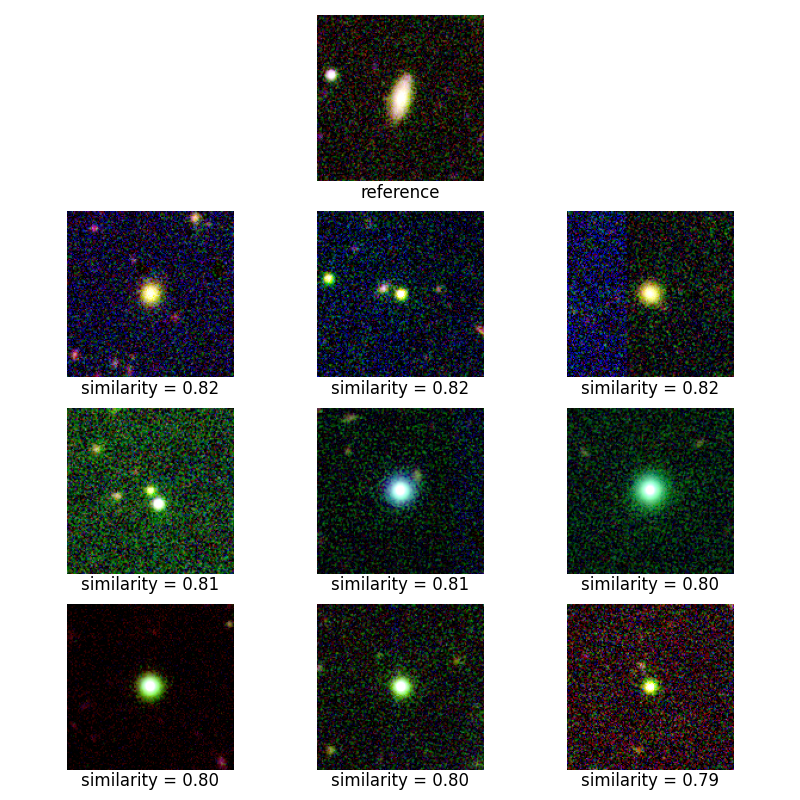

<IPython.core.display.Javascript object>


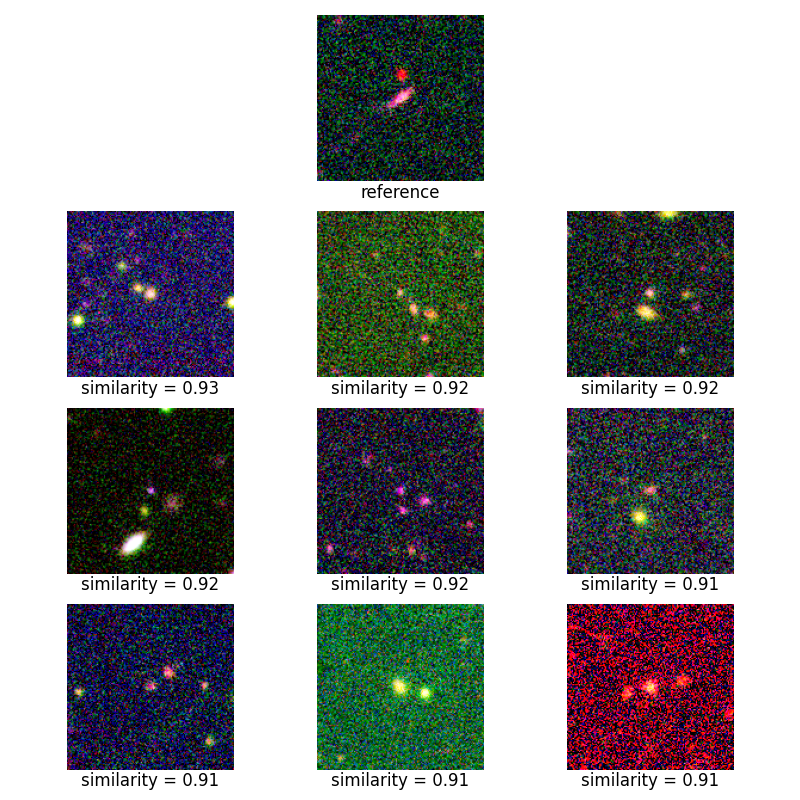

/home/merileo/vissl-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/merileo/vissl-env/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [52]:
%matplotlib notebook
for filepath, indx in interesting_images:
    with h5py.File(filepath, 'r') as f:
        images_temp = f['images'][indx:indx+10]
        images_temp = np.swapaxes(images_temp, 1, 3)
        images_temp = np.float32(images_temp)
        images_temp = np.asarray(([cropper(totensor(im)).detach().numpy() for im in images_temp]))
        ref_im = images_temp[0]
        ref_rep = rn50(torch.unsqueeze(torch.from_numpy(images_temp[0]), dim=0).cuda()).detach().cpu().numpy()
        
    similarity = [1 - spatial.distance.cosine(ref_rep, im_rep) 
                  for im_rep in output_representations_list]

    top10_indices = sorted(range(len(similarity)), key=lambda i: similarity[i])[-10:]
    top10_indices.reverse()

    top10_filepaths = np.asarray(filepaths_list)[top10_indices]
    top10_object_indices = np.asarray(indx_list)[top10_indices]
    top10_similarities = np.asarray(similarity)[top10_indices]

    fig, axes = plt.subplots(4, 3, figsize=(8,8))
    image = process_image(ref_im)
    axes[0][1].imshow(image)
    axes[0][1].axis('off')
    axes[0][1].text(0.5,-0.1, "reference", size=12, ha="center", transform=axes[0][1].transAxes)
    axes = axes.flatten()
    for i in range(9):
        with h5py.File(top10_filepaths[i], 'r') as f:
            image = f['images'][top10_object_indices[i]]
            image = np.swapaxes(image, 0, 2)
            image = np.float32(image)
            image = cropper(totensor(image)).detach().numpy()
        image = process_image(image)
        axes[i+3].imshow(image)
        axes[i+3].axis('off')
        axes[i+3].text(0.5,-0.1, "similarity = {:.2f}".format(top10_similarities[i]), size=12, ha="center", 
             transform=axes[i+3].transAxes)
    fig.delaxes(axes[0])
    fig.delaxes(axes[2])
    plt.tight_layout()